# Searching for New Passengers

On average, one third of taxi and TNC vehicles in Manhattan are empty during peak times.

*Empty Seats, Full Streets: Fixing Manhattan’s Traffic Problem* (Bruce Schaller)

http://schallerconsult.com/rideservices/emptyseats.htm

https://nyc.streetsblog.org/2017/12/21/schaller-curbing-uber-idle-time-key-to-busting-manhattan-gridlock/

Say we're a taxi driver working in a city in which the streets and intersections form, respectively, the vertices and edges of a graph with adjacency matrix A. We've taken careful note of the probability with which we can get a passenger on each street, and we'd like to use this information to limit the amount of time we have to spend driving around to find our next passenger. Where should we drive to minimize this waiting time?

In [6]:
import Pkg
Pkg.activate("TaxiSearch")
using MAT, Setfield, Revise
using TaxiSearch

┌ Info: Precompiling TaxiSearch [b90393e4-a556-11e8-02ce-05c8994ea979]
└ @ Base loading.jl:1186
┌ Warning: No working GUI backend found for matplotlib
└ @ PyPlot ~/.julia/packages/PyPlot/tA0wP/src/init.jl:160


In [2]:
dbgNet = RoadNet(2);

# Example 1: Random Grid

## Graph description

In [7]:
testNet = RoadNet(10);

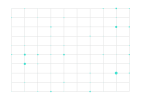

In [4]:
plotG(testNet)

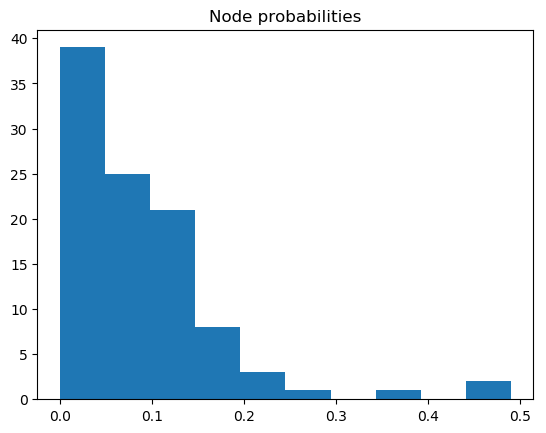

In [8]:
plt[:hist](testNet.lam); plt[:title]("Node probabilities");

## Expected waiting time

Let's assume that the probability of getting a passenger on any given street i within one time-step follows a Bernoulli distribution with probability of success $\lambda_i$.  Let the random variable $X_i$ indicate the number of time-steps it takes for a taxi to find the next passenger starting on street $i$. . Let the indicator random variable $P_i$ be $1$ if our taxi picks up a passenger at street $i$ within one time-step. If all streets take $1$ time-step to traverse and we continue driving until we find a passenger, $X_i = P_i + (1 - P_i)(1 + \min_{j \in N_o(i)}X_j)$, where $N(i)$ givs the outgoing neighbors of street $i$. The expected waiting time $x_i$ for a taxi on street $i$ is given therefore by the fixed point of the following equation:

$$
\label{greedEq}
x_i = \lambda_i+(1-\lambda_i)\left(1+\min_{j\in N(i)}x_j\right)
$$


In the min-plus (tropical) semiring in which the additive group operation is the minimum and the multiplicative group operation is addition, this is written as

$$
x= \lambda+ (1-\lambda)\circ (A \otimes x)
$$

In [10]:
function a1Min(A, lam)
  vals = fixedPoint(x->lam .+ (1 .- lam) .* (1 .+ neighborMin(A, x)[1]), 1 ./ lam)
  ptrs = neighborMin(A, vals)[2]
  pol = ptrPolicy(ptrs)
  (pol, vals, ptrs)
end

a1Min (generic function with 1 method)

In [11]:
testA1Min, testA1MinVals, testA1MinPtrs = a1Min(testNet.g, testNet.lam);

Converged in 59 steps


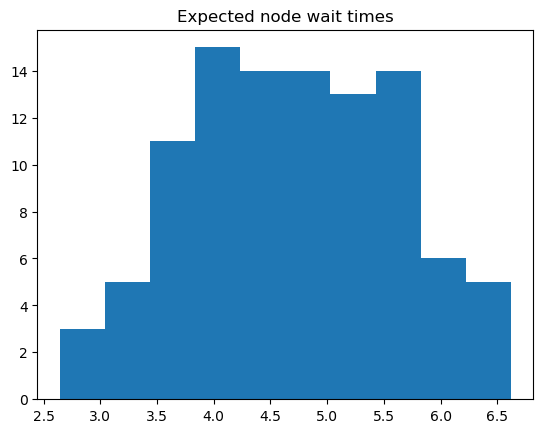

In [11]:
plt[:hist](testA1MinVals); plt[:title]("Expected node wait times");

Empirical results:

In [19]:
realWaits = indivB(collect(1:length(testNet.lam)), testNet, S([nodeWaitTimes],[]), testA1Min, 5000).pol[1][1][2];

In [20]:
realWaitMean = collect(map(mean,realWaits));

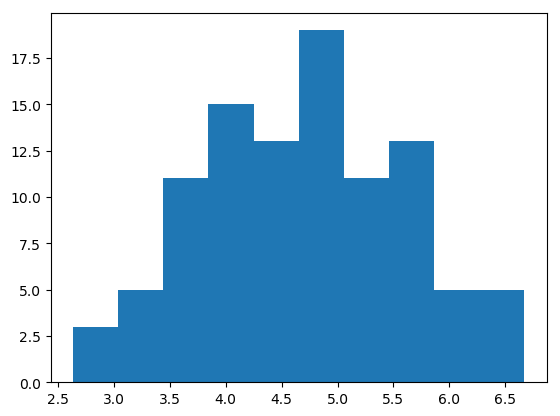

In [23]:
plt[:hist](realWaitMean);

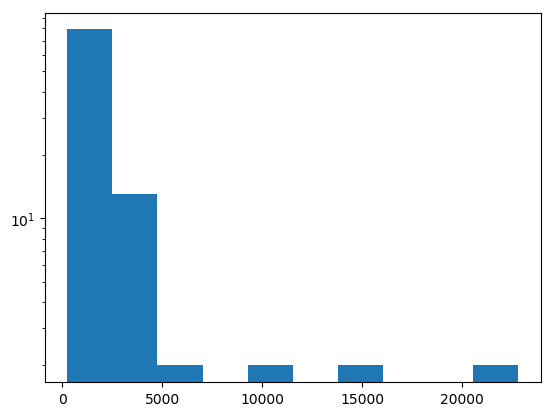

In [25]:
plt[:hist](map(length, realWaits), log=true);

Residuals

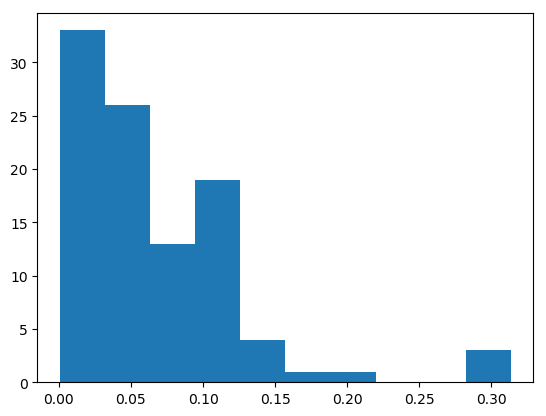

In [46]:
plt[:hist](abs.(realWaitMean - testA1MinVals));

In [28]:
rsquared = 1 - sum((realWaitMean .- testA1MinVals).^2) / sum((realWaitMean .- mean(realWaitMean)).^2)

0.9906347444341632

## Comparison with baseline policies

rand pol 1 stat 1 0.6444887500000002 of 800
trained pol 1 stat 1 0.44990499999999983 of 800
greedy pol 1 stat 1 0.5046737499999999 of 800


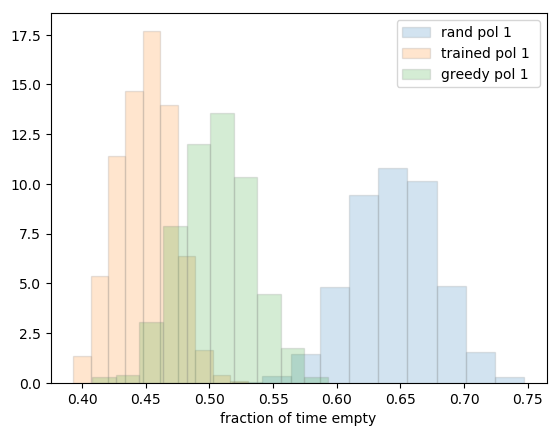

In [12]:
bench(withNTaxis(800, indivB), testNet, S([taxiEmptyFrac],[]), P([:hist],[]), F([id],[]);
  rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

But we're not just doing the easy thing of going to the global max

In [13]:
testH = hotPtrs(testNet);

hot pol 1 stat 1 0.5016900000000001 of 1000
rnd pol 1 stat 1 0.644071 of 1000
trained pol 1 stat 1 0.4506269999999997 of 1000
greedy pol 1 stat 1 0.5044029999999999 of 1000


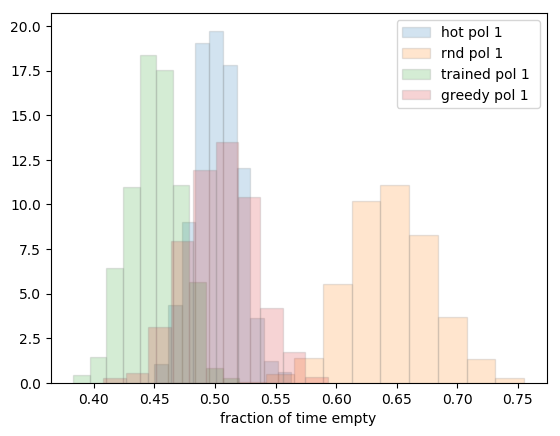

In [14]:
bench(withNTaxis(1000, indivB), testNet, S([taxiEmptyFrac],[]), P([:hist],[]), F([id],[]);
  hot=ptrPolicy(testH), rnd=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

In [15]:
routeDiff(testH, testA1MinPtrs)

0.51

We can also compare the mean wait time means for each node

rand pol 1 stat 1 => 11.4707620452333
trained pol 1 stat 1 => 5.116460658919383
greedy pol 1 stat 1 => 6.565220931429136


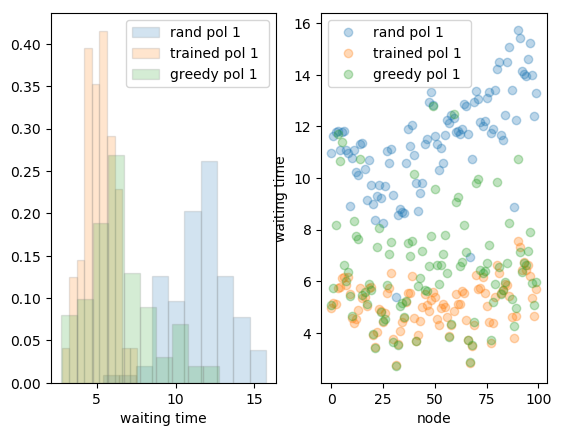

In [47]:
bench(withNTaxis(1000,indivB), testNet, S([nodeWaitTimes], []), P([:hist; :scatter],[]), F([mean],[]);
  rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

Or their standard deviations

rand pol 1 stat 1 => 10.839678359676213
trained pol 1 stat 1 => 3.1353922789460262
greedy pol 1 stat 1 => 5.399092982766722


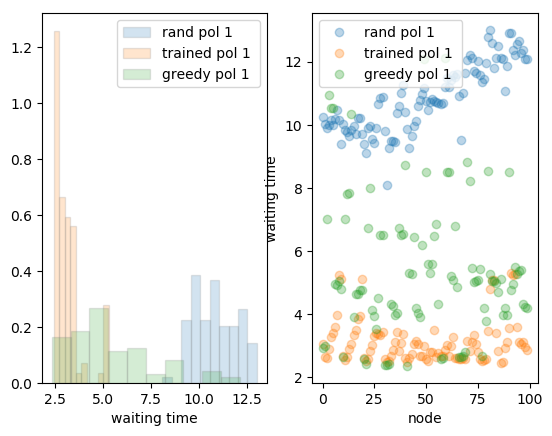

In [48]:
bench(withNTaxis(1000,indivB), testNet, S([nodeWaitTimes], []), P([:hist; :scatter], []), F([std],[]);
  rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

## Changes in entropy 

In [52]:
function gap(f, net)
  order = randperm(size(net.g)[1])
  entropies = Float64[]
  ratios = Float64[]
  for p in -(0.11:0.1:1.2)
    netP = @set net.lam = mkP(order .^ p, 2)
    fP = f(netP)
    push!(entropies, entropy(toDist(netP.lam)))
    push!(ratios, mean(withNTaxis(1000,indivB)(netP, TaxiEmptyFrac, a1Min(netP.g, netP.lam)[1]).pol[1][1]) /
      mean(withNTaxis(1000,indivB)(netP, TaxiEmptyFrac, fP).pol[1][1]))
  end
  plot(entropies, ratios, xlabel="entropy", ylabel="ratio", legend=false)
end

gap (generic function with 1 method)

Converged in 23 steps
Converged in 33 steps
Converged in 42 steps
Converged in 53 steps
Converged in 65 steps
Converged in 79 steps
Converged in 93 steps
Converged in 110 steps
Converged in 128 steps
Converged in 147 steps
Converged in 169 steps


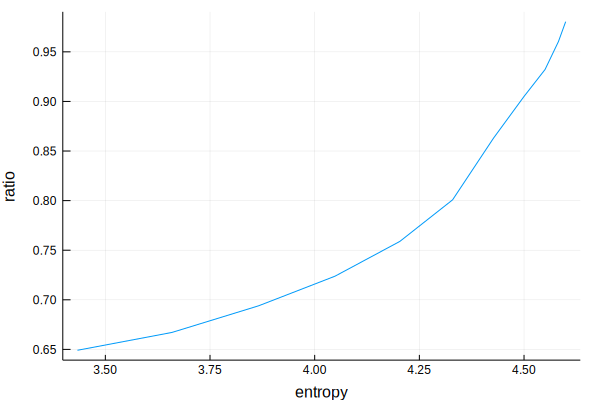

In [53]:
gap(greedyPol, testNet)

## Tracing the routes

In [19]:
testA1MinG = LG.DiGraph(testA1Min');

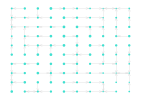

In [20]:
plotG(testA1MinG, testNet, testA1MinVals)

These routes settle into fixed basins of attraction

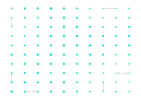

In [21]:
plotG(justCycles(testA1MinG), testNet, testA1MinVals)

## Competing agents

pol 1 rand 1 0.8821480000000002
pol 1 rand 2 49.40922038357865
pol 1 trained 1 0.9550239999999997
pol 1 trained 2 125.71533116765782
pol 1 greedy 1 0.94901
pol 1 greedy 2 96.0163648621618


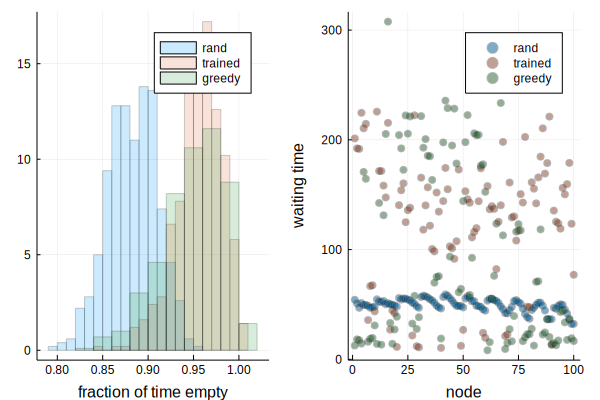

In [69]:
bench(withNTaxis(500,competB), [:hist, :scatter], testNet, [TaxiEmptyFrac, Agg(mean, NodeWaitTimes)]; rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

The situation isn't good for passengers either

gbl rand 1 0.031003862714691934
gbl trained 1 0.8423415189515137
gbl greedy 1 0.7540935425719133


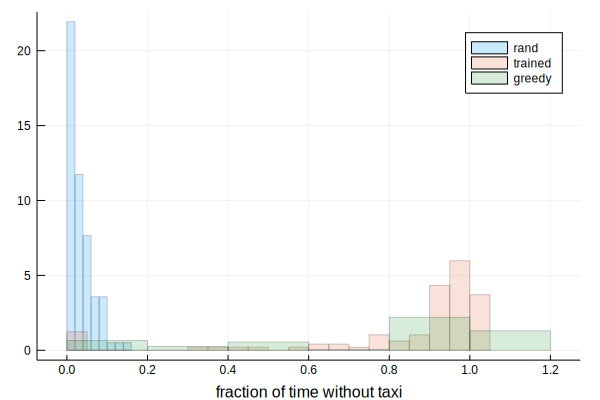

In [78]:
bench(withNTaxis(500, competB), :hist, testNet, NodeSOLFrac; rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

Individually optimal taxis all go to the same place

gbl rand 1 11.632
gbl trained 1 109.721
gbl greedy 1 68.495


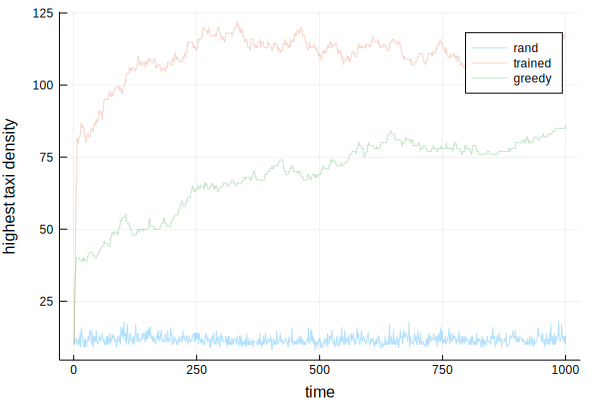

In [81]:
bench(withNTaxis(500, competB), :line, testNet, MaxCars; rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

In [77]:
meanEmptyFrac(n, net, p) = mean(withNTaxis(n, competP)(net, S([taxiEmptyFrac],[]), p).pol[1][1][2])

meanEmptyFrac (generic function with 1 method)

In [80]:
xs = 2:3:300

2:3:299

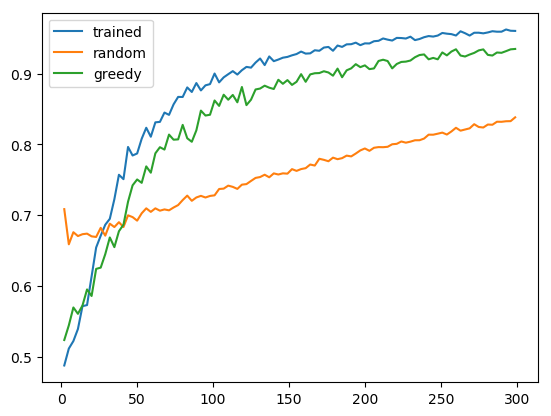

PyObject <matplotlib.legend.Legend object at 0x7f624ba7f6d8>

In [83]:
plt[:plot](xs, [meanEmptyFrac(i, testNet, testA1Min) for i in xs], label="trained")
plt[:plot](xs, [meanEmptyFrac(i, testNet, randPol(testNet)) for i in xs], label="random")
plt[:plot](xs, [meanEmptyFrac(i, testNet, greedyPol(testNet)) for i in xs], label="greedy")
plt[:legend]()

## All smart cabs

A better solution is to bake competition into our model directly.

The vector of trip request rates is $\lambda$, and the vector of taxi densities (not including the taxi in consideration) is $\rho$. We assume that the probability a particular taxi gets a trip is $\left(\frac{\lambda}{\rho+1}\right)$. The number of passengers looking for a ride is Poisson with rate $\lambda$. The probability of an individual taxi getting the passenger (given one is generated) is just $1 - \prod_{i=0}^{\rho}\frac{\rho-i}{\rho-i+1}$. Everything cancels except $\rho/(\rho + 1)$.


Let $\Pi_\rho$ be the policy followed when densities are at $\rho$. Let $\rho'$ be the new densities after one timestep has passed. We don't know exactly what these new densities will be, but we can sample from a Poisson with rate $\lambda$ and subtract this from $\rho$, keeping everything about 0. Then the expected waiting time for a taxi introduced at a node $i$ is given by $x_i$ where

$$ x_\rho = \frac{\lambda}{\rho + 1} + \left(1 - \frac{\lambda}{\rho + 1}\right) (1 + \Pi_{\rho'}^Tx_{\rho'})$$

When this policy has all taxis choose the road with minimum wait time, we get the equation
$$ x_\rho = \frac{\lambda}{\rho + 1} + \left(1 - \frac{\lambda}{\rho + 1}\right) (A \circ x_{\rho'})$$

In [95]:
using Knet, VisdomLog

In [108]:
ModelTy = Tuple{Array{Float64,2}, Vec}

Tuple{Array{Float64,2},Array{Float64,1}}

In [97]:
predict(params, rho) = (params[1] * rho .+ params[2]).^2 .+ 1

predict (generic function with 1 method)

In [290]:
function minLoss(params, rho, A, lam, plam)
  timeEst = predict(params, rho)
  pol = ptrPolicy(neighborMin(A, getval(timeEst))[2])
  p = lam ./ (rho .+ 1)
  newRho = sampleNewRho(pol, plam, rho)
  newEst = getval(predict(params, newRho))
  unlucky = (1 .- p) .* (1 .+ neighborMin(A, newEst)[1])
  mean(abs2, (p .+ unlucky) - timeEst)
end

minLossFn = gradloss(minLoss);

In [282]:
function sampleNewRho(pol, plam, rho)
  found = rand.(plam)
  postFound = max.(0, rho - rand.(plam))
  pol * postFound
end

sampleNewRho (generic function with 1 method)

As before, the policy matrix $\Pi_\rho$ is just $1/x_\rho$ multiplied columnwise on the adjacency matrix and normalized

In [284]:
struct StopTraining <: Exception end

In [352]:
function keepTraining(A::Graph, lam::Vec, k::Int, model::ModelTy, lossF)
  plam = Poisson.(lam)
  roads = length(lam)
  visdom = Visdom("traceVals3", [:loss, :w, :b]);
  o = optimizers(model, Adam, lr=0.01);
  running_loss = 0.0
  i = 0
  try
    while true
      yield()
      i += 1
      rho = trunc.(min.(10.0, randexp(roads) .* k))
      g, l = lossF(model, rho, A, lam, plam)
      running_loss += l
      if i % 100 == 0
        report(visdom, :loss, [running_loss / 100.0])
        VisdomLog.inform(visdom, :w, model[1])
        VisdomLog.inform(visdom, :b, model[2])
        running_loss = 0.0
      end
      update!(model, g, o)
    end
  catch e
    if isa(e, StopTraining)
      return model
    end
    rethrow()
  end
end

keepTraining (generic function with 3 methods)

In [345]:
# Dang, we can't use KNet on sparse matrices. 
# Should we abandon Knet? Could just do backprop manually. Or use ReverseDiff.
function train(A::Graph, lam::Vec, k::Int, mask::Graph, loss)
  roads = length(lam)
#   w = SparseMatrixCSC(mask.m, mask.n, mask.colptr, mask.rowval,
#     0.01*rand(length(mask.nzval)))
  w = sqrt.(abs.(randn(size(A))))
  b = sqrt.(1 ./ lam) .- 1
  keepTraining(A, lam, k, (w, b), loss)
end

train (generic function with 2 methods)

In [110]:
neighborhoods(g::Graph, n::Int)::Graph = (g + speye(g))^n .> 0

neighborhoods (generic function with 1 method)

But having each taxi follow the identical greedy policy does not converge. Whenever taxis find a better place to go, everyone goes there, and it no longer beomes a good place. A proportional policy works much better.

In [286]:
function propLoss(params, rho, A, lam, plam)
  timeEst = predict(params, rho)
  pol = scorePolicy(1 ./ getval(timeEst), A)
  p = lam ./ (rho .+ 1)
  newRho = sampleNewRho(pol, plam, rho)
  newEst = getval(predict(params, newRho))
  newPol = scorePolicy(1 ./ newEst, A)
  unlucky = (1 .- p) .* (1 .+ (newPol.' * newEst))
  mean(abs2, p + unlucky - timeEst)
end

propLossFn = gradloss(propLoss);

In [350]:
t2 = @schedule train(testA, testLam, 2, neighborhoods(testA, 8), propLossFn)

Task (queued) @0x00007f568e5197b0

In [351]:
schedule(t2, StopTraining(), error=true);

LoadError: [91mschedule: Task not runnable[39m

In [298]:
testModel = fetch(t2);

In [299]:
testPol= rho->scorePolicy(1 ./ predict(testModel, rho), testA);

Trained parameters

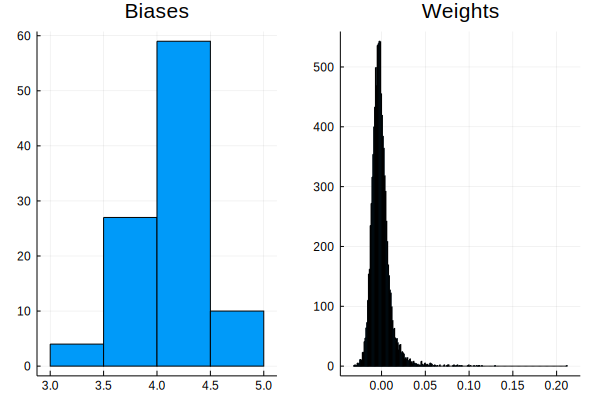

In [300]:
plot(histogram(testModel[2][:], legend=false, title="Biases"),
  histogram(testModel[1][:], legend=false, title="Weights"))

Competative waiting times

rand 0.7382954545454546
trained 0.7300530303030304
indep 0.8866287878787878


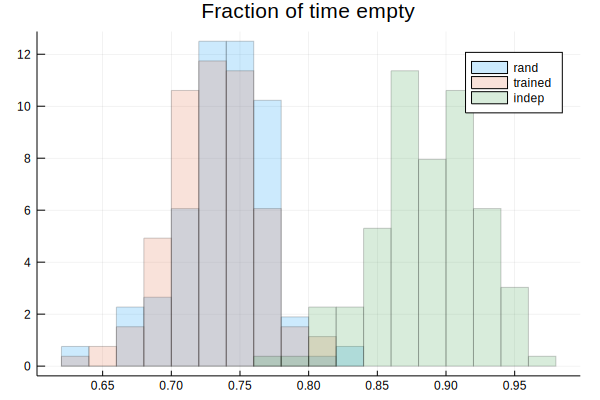

In [302]:
compareFor(compet(testLam), testM, testDists, 2; rand=randPol(testA,testLam), trained=testPol, indep=testA1Min) 

## Heterogenous environments

In [72]:
smarty = solo(testA1Min, randPol(testNet));

mixed pol 1 stat 1 => 0.486
mixed pol 2 stat 1 => 0.69


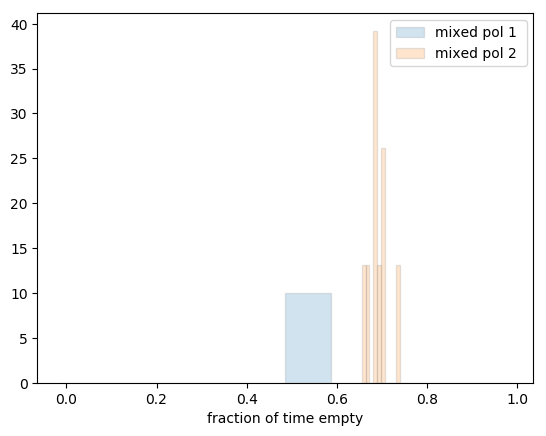

In [58]:
bench(withNTaxis(10, competP), testNet, S([taxiEmptyFrac], []), P([:hist],[]), F([id],[]); mixed=smarty)

mixed pol 1 stat 1 => 0.67
mixed pol 2 stat 1 => 0.8320668896321071


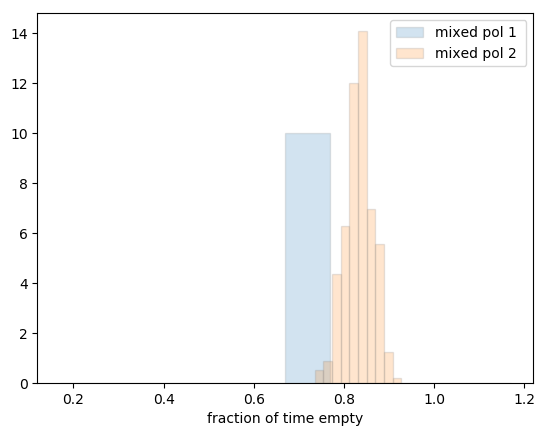

In [54]:
bench(withNTaxis(300, competP), testNet, S([taxiEmptyFrac], []), P([:hist],[]), F([id],[]); mixed=smarty)

mixed pol 1 stat 1 => 0.863
mixed pol 2 stat 1 => 0.9294367959949936


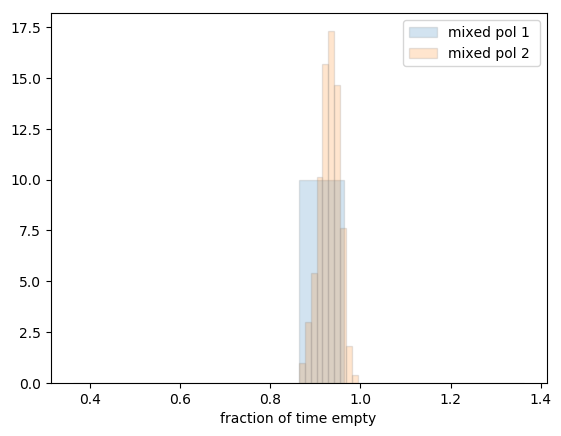

In [56]:
bench(withNTaxis(800, competP), testNet, S([taxiEmptyFrac], []), P([:hist],[]), F([id],[]); mixed=smarty)

In [68]:
function polGap(p, net, n)
  p1, p2 = withNTaxis(n, competP)(net, S([taxiEmptyFrac], []), p).pol
  mean(p2[1][2]) - mean(p1[1][2])
end

polGap (generic function with 2 methods)

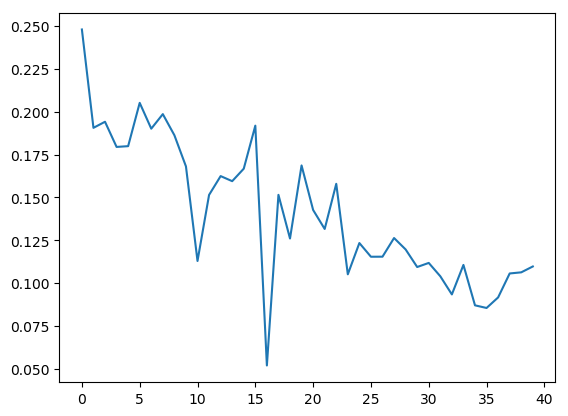

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f624bcbdf60>

In [70]:
plt[:plot]([polGap(smarty, testNet, n) for n in 2:25:1000]);

## Dealing with variance

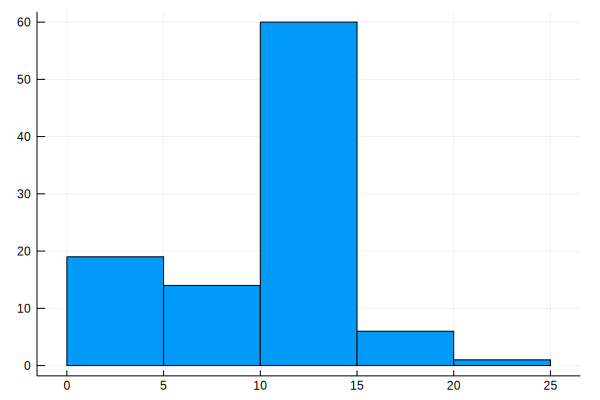

In [33]:
histogram(var.(realWaits), legend=false)

$\newcommand{\E}{\mathrm{E}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$

Let $y = \E[X^2]$ be the expected squared waiting time. Then
$$
y_i = \lambda_i + (1-\lambda_i)(1 + y^* + 2\sqrt{y^*}) \text{ where } y^* = \min_{j \in N(i)} y_j
$$

The variance is given by $\Var[X] = y - x^2$. 

In [35]:
function a1MinSq(net)
  fixedPoint(y-> begin
    yStar = neighborMin(net.g, y)[1]
    net.lam .+ (1 .- net.lam) .* (1 .+ yStar .+ 2 .* sqrt.(yStar))
    end, 1 ./ net.lam)
end

a1MinSq (generic function with 2 methods)

In [36]:
testA1MinVar = a1MinSq(testNet) .- testA1MinVals.^2;

Converged in 100 steps


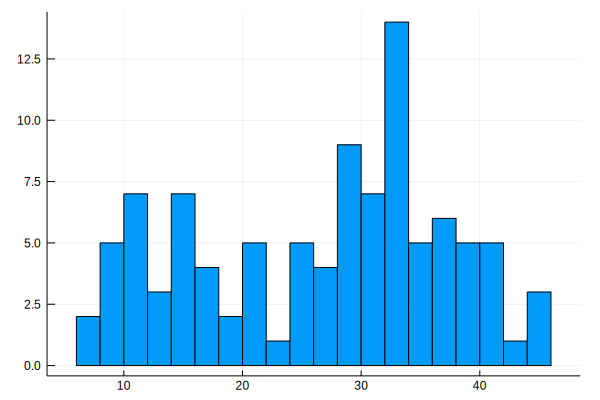

In [37]:
histogram(testA1MinVar, nbins=25, legend=false)

Residuals from our prediction:

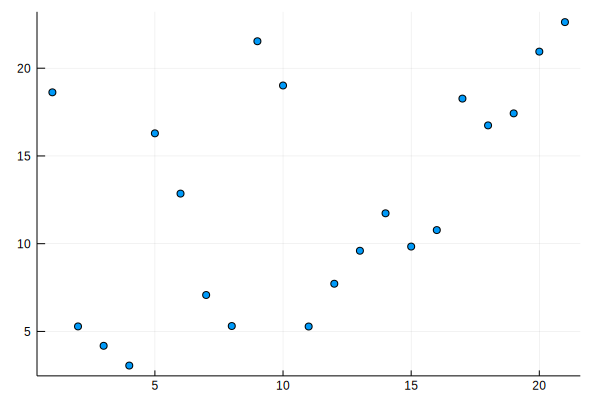

In [38]:
scatter(nonNan(abs.(map(x->length(x) > 2000 ? var(x) : NaN, realWaits) - testA1MinVar)), legend=false)

## Conservative policies

In [21]:
testA1MinCons = greedyPol(testNet, testA1MinVals .+ sqrt.(testA1MinVar));

LoadError: UndefVarError: testA1MinVar not defined

In [42]:
testA1MinCons2 = greedyPol(testNet, testA1MinVals .+ std.(realWaits));

expected 0.43085999999999997
conservative1 0.7466349999999999
conservative2 0.73346


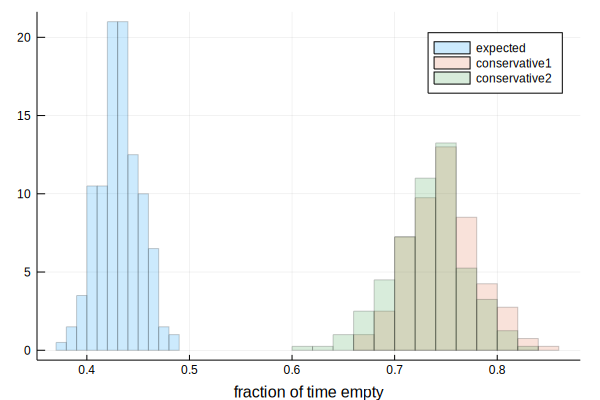

In [49]:
bench(withNTaxis(200, indivB), id, :hist, testNet, TaxiEmptyFrac; expected=testA1Min, conservative1=testA1MinCons, conservative2=testA1MinCons2)

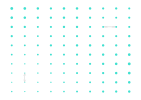

In [56]:
theTime =  testA1MinVals .+ sqrt.(testA1MinVar)
plotG(justCycles(ptrPolicy(neighborMin(testNet.g,theTime)[2])), testNet, theTime)

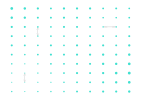

In [60]:
plotG(justCycles(testA1Min), testNet, testA1MinVals)

## Scaling probabilities

Assume passengers hang around for $\delta$ time-steps after generation

This is equivalent to increasing the probabilities at each node by a factor of $\delta$. Interestingly, increasing the probabilities by a constant factor changes the optimal route by over 25%!

Converged in 50 steps
Route fraction changed: 0.1


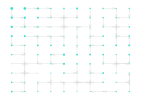

In [7]:
testA1Min2, testA1MinVals2, testA1MinPtrs2 = a1Min(testNet.g, testNet.lam .* 3)
println("Route fraction changed: ", norm(testA1MinPtrs - testA1MinPtrs2, 0) / length(testA1MinPtrs))
plotG(testA1Min2, testNet, testA1MinVals2)

This also makes them settle into different basins of attraction. 

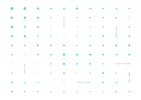

In [9]:
plotG(justCycles(testA1Min2), testNet, testA1MinVals2)

In [23]:
function inflationGap(A, lam)
  xs = collect(1.1:0.2:5)
  orig = a1Min(A, lam)[3]
  plot(xs, [norm(orig - a1Min(A, lam .* n)[3], 0) ./ length(orig) for n in xs])
end

inflationGap (generic function with 1 method)

Converged in 65 steps
Converged in 59 steps
Converged in 59 steps
Converged in 48 steps
Converged in 42 steps
Converged in 46 steps
Converged in 42 steps
Converged in 40 steps
Converged in 37 steps
Converged in 34 steps
Converged in 30 steps
Converged in 28 steps
Converged in 26 steps
Converged in 24 steps
Converged in 22 steps
Converged in 26 steps
Converged in 31 steps
Converged in 36 steps
Converged in 43 steps
Converged in 50 steps
Converged in 58 steps


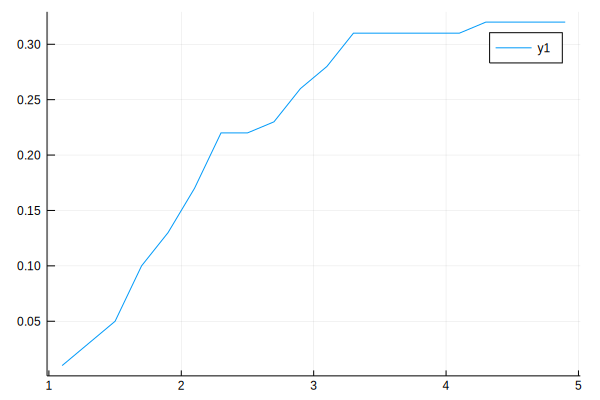

In [24]:
inflationGap(testNet.g, testNet.lam)

## Using rates, not probabilities

The lambdas can be rates of passenger pickup, not probabilities. That way we move to variable length streets without the icky equation. The waiting time will come from an exponential distribution. We need to know the probability that the exponential variable is greater than some amount (the street length). That's 1 - the cdf of the exponential ($1 - e^{\lambda x}$). This new form is therefore:

$$ x_i = (1 - e^{-\lambda_i L_i})(\lambda_i^{-1} - l(e^{\lambda_i L_i} - 1)^{-1}) + e^{-\lambda_i L_i}\left( L_i + \min_{j \in N(i)} x_j \right)$$

See
https://www.quora.com/Does-the-truncated-exponential-distribution-have-an-expected-value, http://thescipub.com/PDF/jmssp.2008.284.288.pdf

In [5]:
truncExpMu(lam, l) = (1 ./ lam) - l ./ (exp.(lam .* l) .- 1)

truncExpMu (generic function with 1 method)

In [6]:
function a1RMin(A, lam, len)
  p = exp.(-lam .* len)
  vals = fixedPoint(x->truncExpMu(lam, len) .* (1 .- p) .+ p .* (len .+ neighborMin(A, x)[1]), 1 ./ lam)
  ptrs = neighborMin(A, vals)[2]
  pol = ptrPolicy(ptrs)
  (pol, vals, ptrs)
end

a1RMin (generic function with 1 method)

In [20]:
testRMin, testRVaks, testRPtrs = a1RMin(wSize.g, wSize.lam, wSize.lam);

Converged in 81 steps


In [19]:
wSize = @set testNet.len = ones(length(testNet.lam));
# wSize = @set wSize.lam = toContinuous.(wSize.lam);

In [ ]:
# They're sooo different. Check this out. 

In [21]:
routeDiff(testRPtrs, testA1MinPtrs)

0.7

In [ ]:
# Something is very messed up.

bernoulli 0.3979533992180826
exp 0.5205196137129312


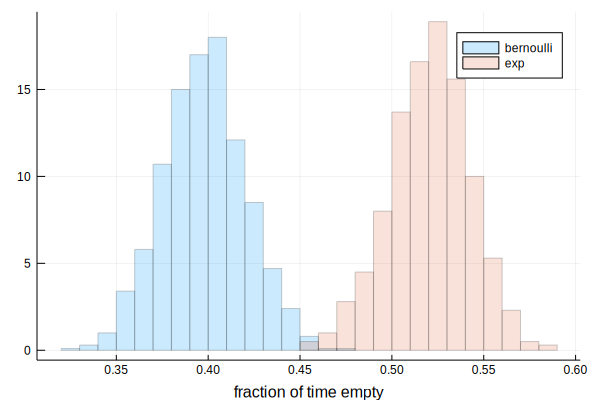

In [22]:
bench(withNTaxis(1000,indivE), id, :hist, wSize, TaxiEmptyFrac;
  bernoulli=testA1Min, exp=testRMin)

In [56]:
testLNet = changeLen(testNet, abs.(randn(length(testNet.lam)) .* 0.3 .+ 1))
testLNet = @set testLNet.lam = toContinuous.(testLNet.lam);

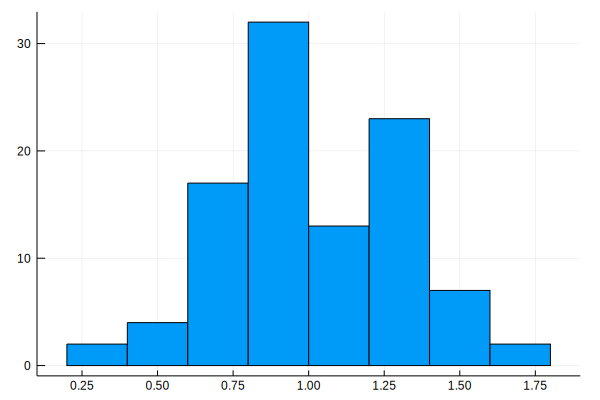

In [53]:
histogram(testLNet.len, legend=false)

In [57]:
testRate, testRateVals, testRatePtrs = a1RMin(testLNet.g, testLNet.lam, testLNet.len);

Converged in 69 steps


bernoulli 0.8329933329702918
exp 0.48540863546729096
rand 0.6933209186341301


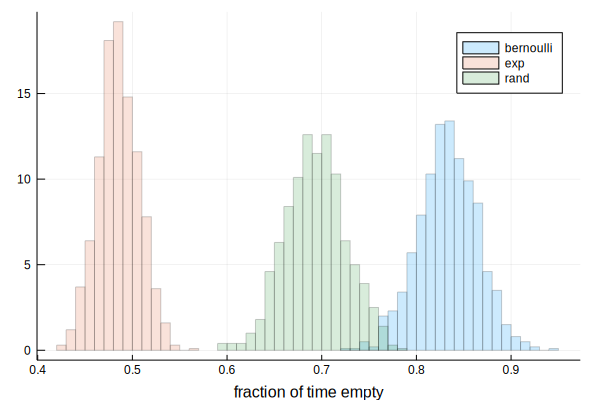

In [63]:
bench(withNTaxis(1000,indivE), id, :hist, testLNet, TaxiEmptyFrac;
  bernoulli=testA1Min, exp=testRate, rand=randPol(testLNet))

In [67]:
function expGap(net0, bernMin)
  order = randperm(size(net0.g)[1])
  entropies = Float64[]
  ratios = Float64[]
  for p in -(0.01:0.5:2.5)
    len = mkP(order .^ p, 0.1)
    push!(entropies, entropy(toDist(len)))
    net = changeLen(net0, len)
    push!(ratios, 
      mean(withNTaxis(800, indivE)(net, TaxiEmptyFrac, uni(a1RMin(net.g, net.lam, net.len)[1])).pol[1][1]) /
      mean(withNTaxis(800, indivE)(net, TaxiEmptyFrac, bernMin).pol[1][1]))
  end
  plot(entropies, ratios, xlabel="entropy", ylabel="ratio with bernoulli", legend=false)
end

expGap (generic function with 1 method)

Converged in 13 steps
Converged in 51 steps
Converged in 178 steps
Converged in 1201 steps
Converged in 5733 steps


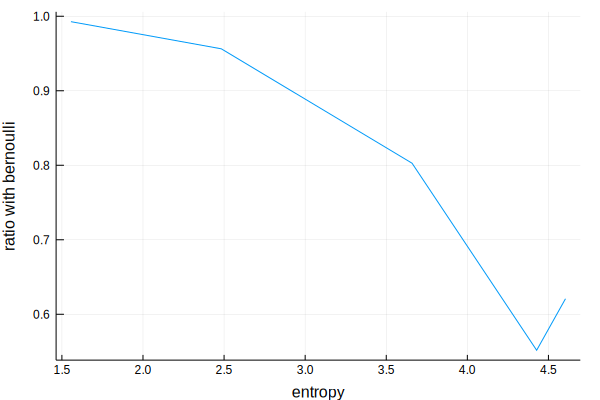

In [68]:
expGap(testLNet, uni(testA1Min))

## Proportional policy

Instead of having drivers always turn onto the street that will give them the smallest expected waiting time, we can have them turn onto streets randomly in inverse proportion to expected waiting time.


$$
\label{propEq}
x = \lambda + (1 - \lambda)(1 + \Pi_x^T x)
$$



The policy matrix $\Pi$ is just $1/x$ multiplied columnwise on the adjacency matrix and normalized.

In [23]:
function a1Prop(A, lam)
  vals = fixedPoint(x-> lam .+ (1 .- lam) .* (1 .+ scorePolicy(1 ./ x, A)' * x), 1./ lam)
  (c(scorePolicy(1 ./ vals, A)), vals)
end

a1Prop (generic function with 1 method)

In [24]:
testA1Prop, testA1PropVals = a1Prop(testA, testLam);

Converged in 105 steps


This doesn't do any better than greedy

rand 0.8441145038167938
prop 0.8347150127226461
greedy 0.8444045801526717


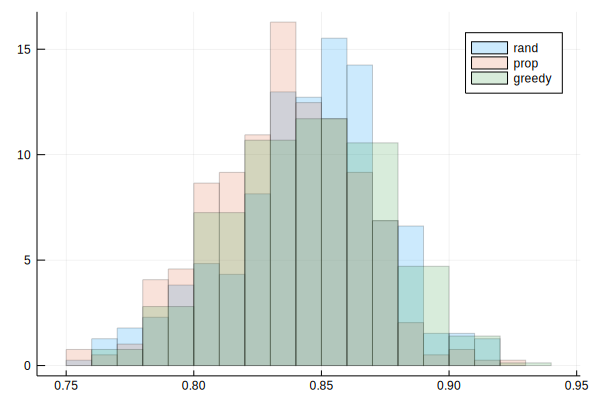

In [29]:
bench(competB, testLam, testM, testSt.dists, 5;
  rand=c(randPol(testA,testLam)), prop=testA1Prop, greedy=c(greedyPolProp(testA, testLam)))

Especially when competition is less.

rand 0.6816199999999999
prop 0.64542
greedy 0.58896


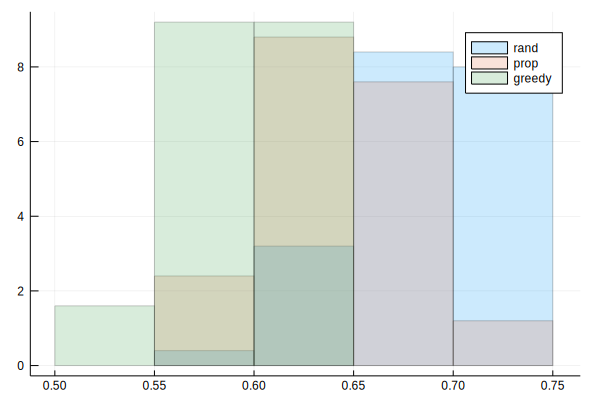

In [33]:
bench(competB, testLam, testM, testSt.dists, 1;
  rand=c(randPol(testA,testLam)), prop=testA1Prop, greedy=c(greedyPolProp(testA, testLam)))

Or nonexistent:

rand 0.6143593153652186
prop 0.5785048259400095
greedy 0.5130316171088611


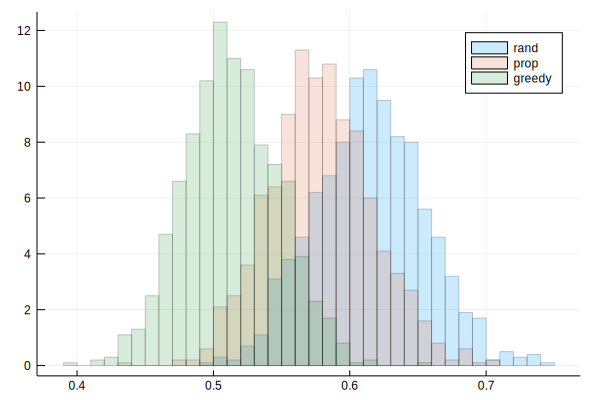

In [34]:
bench(indivB, testLam, testM, testSt.dists;
  rand=randPol(testA,testLam), prop=testA1Prop(true), greedy=greedyPolProp(testA, testLam))

rand 9.22
trained 11.022
greedy 20.718


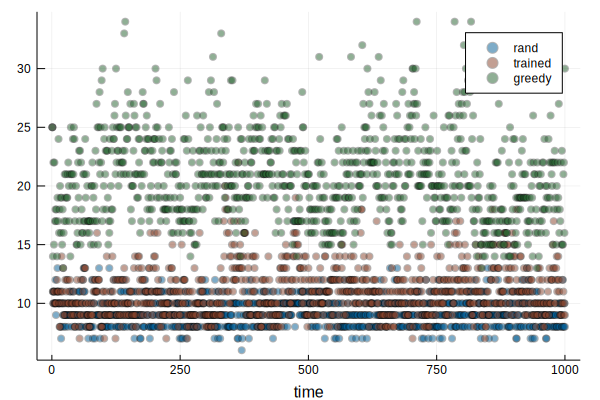

In [33]:
benchS(concentrations(competBDist), "time", testLam, testM, testSt.dists, 5; rand=c(randPol(testA,testLam)), trained=testA1Prop, greedy=c(greedyPolProp(testA, testLam)))

## Boltzman exploration

We can try to do something in between the two- favoring directions with shorter expected directions using Boltzmann exploration

In [35]:
boltz(x) = exp.(x .* 4)

boltz (generic function with 1 method)

In [38]:
function a1Boltz(A, lam)
  vals = fixedPoint(x-> lam .+ (1 .- lam) .* (1 .+ scorePolicy(boltz(1 ./ x), A)' * x), 1./ lam)
  (c(scorePolicy(boltz(1 ./ vals), A)), vals)
end

a1Boltz (generic function with 1 method)

In [39]:
testA1Boltz, testA1BoltzVals = a1Boltz(testA, testLam);

Converged in 149 steps


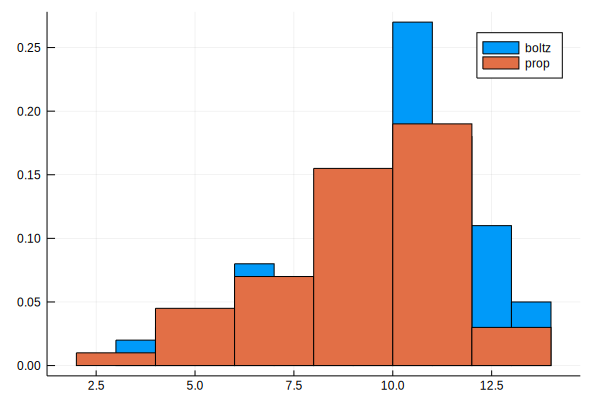

In [40]:
histogram([testA1BoltzVals testA1PropVals], label=["boltz" "prop"], normed=true)

rand 0.7737385321100916
boltz 0.7597614678899082
greedy 0.7557706422018349


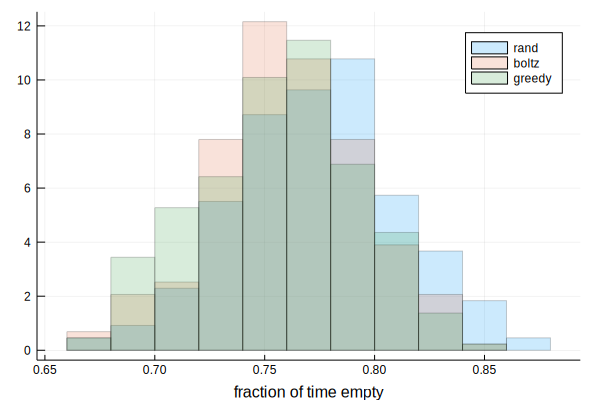

In [44]:
bench(competB, testLam, testM, testSt.dists, 3; rand=c(randPol(testA,testLam)), boltz=testA1Boltz, greedy=c(greedyPolProp(testA, testLam)))

But this doesn't seem to work very well either. 

## Repel policy

How does this compare to the 'repel' strategy: always go where there are the least taxis?

In [ ]:
# ah, we need to look one step ahead. Smartness is overrated. 

rand 0.828941475826972
greedy 0.8348447837150126
smartGreedy 0.8665979643765904


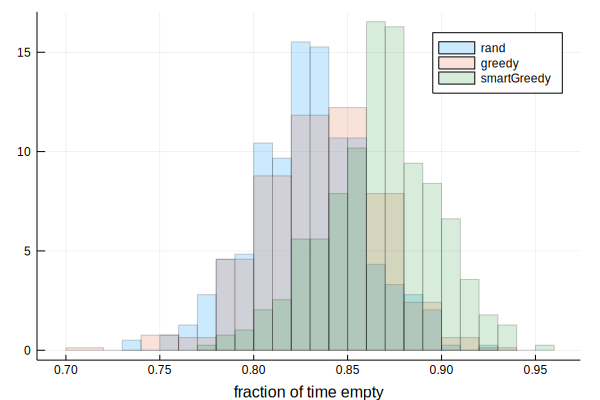

In [57]:
bench(competB, testLam, testM, testSt.dists, 5; rand=c(randPol(testA,testLam)), greedy=c(greedyPolProp(testA, testLam)),
smartGreedy=greedyF(testA, testLam))

### Debugging

In [35]:
rho0 = zeros(Int,testRoads)
rho0[1] = 1
rho0[2] = 1
rho0[11] = 1

1

In [55]:
replay(testG, testX, testY, testM, testLam, testSt.dists, greedyF(testA, testLam), rho0)

Reel.Frames{MIME{Symbol("text/html")}}("/tmp/tmpVYcEZ0", 0x000000000000000a, 1.0, nothing)

##  One smart, others greedy

If the probability of a taxi getting a passenger is independent of the actions of other taxis, then the values $x_i$ are not only useful to an individual taxi driver, but to a taxi fleet operator as well. They will want to minimize the total waiting time of all the taxis in their fleet. The expected total waiting time is just the sum of the individual expected waiting times for each taxi, which are minimized by the equation above. This is not true, however, if we assume that taxis must compete for passengers. 

$$x_\rho= \frac{\lambda}{\rho + 1} + \left(1 - \frac{\lambda}{\rho + 1}\right)
\left(A \circ \Pi_g (\max(0, \rho - (1-\lambda))) \right) $$

Alternately, we could sample. 

rand 0.8660579999999999
trained 0.9587699999999997
greedy 0.9336579999999998


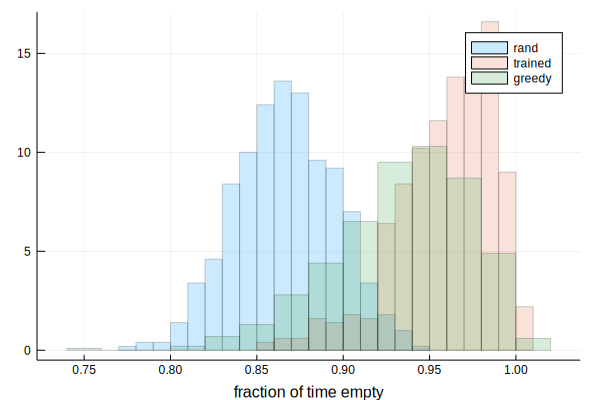

In [59]:
bench(withNTaxis(500,competB), fst, :hist, testNet, TaxiEmptyFrac;
  rand=c(randPol(testNet)), trained=solo(c(testA1Min), c(randPol(testNet)))

# Example 2: Train Station

## Graph description

In [25]:
station = LG.Grid([6,6])
LG.add_vertices!(station, 5)
for i in 36:41
  LG.add_edge!(station, i, i+1)
end
station_lam = [fill(0.1, 36); fill(0.001, 5)]
station_lam[1] = 0.5
station_lam[19] = 0.3
station_M = ones(41,41)
station_M -= spdiagm(diag(station_M));
station_M[1:36,37:41] = 0
station_M[37:41,1:36] = 0
station_M[1,:] = 0
station_M[1,37] = 1
station_M[:, 1] = 0
station_M ./= sum(station_M, 2);
station_A = copy(LG.adjacency_matrix(station, Float64)')
station_dists = dists(station);

In [71]:
stationX, stationY = spring_layout(station);

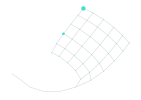

In [72]:
gplot(station, stationX, stationY, nodesize=station_lam)

## N-trip waiting time

There are situations in which minimizing the waiting time before trip $t$ can end up increasing your waiting time before trip $t+1$. Outside a train station, for example, the probability of finding a passenger is quite high. But potential passengers outside a train station are likely to want to go into residential areas where a taxi is far less likely to get hailed. On reflection, it seems we are not interested in minimizing the waiting time before the next trip so much as minimizing the sum of all waiting time over the course of a sufficiently long period. This requires knowledge of passengers' trip probabilities. Let $M_{ij}$ be the probability a passenger who hails a ride at street $i$ is going to street $j$. Let $x_i^n$ be the expected total waiting time over $n$ trips starting from street $i$. Assume unit length streets for simplicity. 

Expected $n$-trip waiting time:

$$
\label{unitMulti}
x^0 = 0 \\
x^n = P(1 + M^Tx^{n-1}) + Q(A \otimes x^n)
$$

With a proportional policy, this is 
$$
x^0 = 0 \\
x^n = P(1 + M^Tx^{n-1}) + Q(1 + \Pi_{x_n}^T x^n)
$$

In [159]:
# Proportional dispatch
function a1T2Prop(A, lam, M; ahead=3)
  vals = iterated(oldX-> fixedPoint(x-> lam .* (1 .+ M * oldX) .+ (1 .- lam) .* (1 .+ scorePolicy(1 ./ x, A)' * x),
      oldX .+ 1 ./ lam), ahead, zeros(length(lam)))
  (constant(scorePolicy(1 ./ vals, A)), vals)
end

# Greedy dispatch
function a1T2Min(A, lam, M; ahead=3)
  vals = iterated(oldX-> fixedPoint(x-> lam .* (1 .+ M * oldX) .+ (1 .- lam) .* (1 .+ neighborMin(A, x)[1]),
      oldX .+ 1 ./ lam), ahead, zeros(length(lam)))
  ptrs = neighborMin(A, vals)[2]
  pol = ptrPolicy(ptrs)
  (constant(pol), vals, LG.DiGraph(pol'), ptrs)
end

a1T2Min (generic function with 1 method)

## Single trip comparison

In [ ]:
testA1Min, testA1MinVals, testA1MinPtrs = a1Min(testA, testLam);

The one-trip equation naively gives the corner intersection a low expected wait time:

Converged in 51 steps


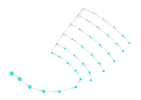

In [84]:
station_pol, station_vals, station_ptrs = a1Min(station_A, station_lam);
gplot(station_g, stationX, stationY, nodesize=station_vals, arrowlengthfrac=0.06)

The ideal route, supposedly, ends up hanging around this corner intersection, waiting for a ride that will take it into an unpopular part of town.

Basin of attraction

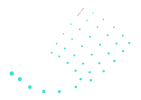

In [97]:
gplot(justCycles(station_g), stationX, stationY, arrowlengthfrac=0.06, nodesize=station_vals)

If we look at the probabilities from $M$, it's clear that this can be counterproductive:

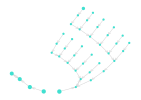

In [102]:
next_vals = station_M * station_vals
next_pol = ptrPolicy(neighborMin(station_A, next_vals)[2])
gplot(LG.DiGraph(next_pol.'), stationX, stationY, nodesize=next_vals, arrowlengthfrac=0.06)

The multi-trip formulation accounts for this:

Iteration 1
Converged in 51 steps
Iteration 2
Converged in 75 steps


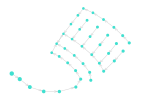

In [100]:
station_pol2, station_vals2, station_g2, station_ptrs2 = a1T2Min(station_A, station_lam, station_M; ahead=2);
gplot(station_g2, stationX, stationY, nodesize=station_vals2, arrowlengthfrac=0.06)

The basin of attraction is now safely away from the corner intersection.

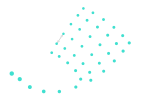

In [101]:
gplot(justCycles(station_g2), stationX, stationY, arrowlengthfrac=0.06, nodesize=station_vals2)

In [104]:
norm(station_ptrs - station_ptrs2, 0) / length(station_ptrs)

0.3170731707317073

Simulated waiting times

single 0.8161649484536083
multi 0.6172061855670101


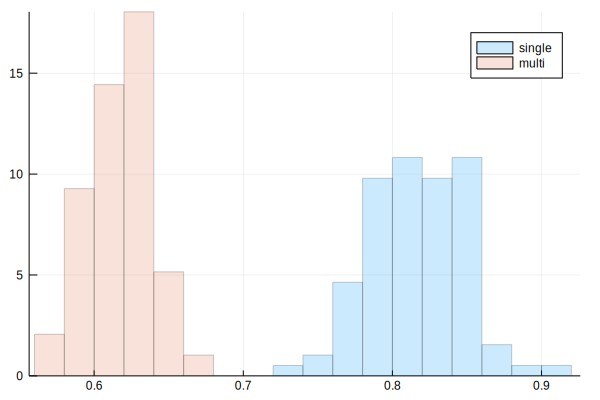

In [50]:
compareFor(indep(station_lam), station_M, station_dists, 3; single=constant(station_pol), multi=constant(station_pol2))

## Entropy comparison

We don't expect to see any real difference when $M$ has no structure, however. 

In [115]:
testA1T2Min, _, testA1T2MinPtrs = a1T2Min(testA, testLam, testM; ahead=20);

Iteration 1
Converged in 73 steps
Iteration 2
Converged in 68 steps
Iteration 3
Converged in 67 steps
Iteration 4
Converged in 66 steps
Iteration 5
Converged in 65 steps
Iteration 6
Converged in 64 steps
Iteration 7
Converged in 63 steps
Iteration 8
Converged in 63 steps
Iteration 9
Converged in 62 steps
Iteration 10
Converged in 62 steps
Iteration 11
Converged in 61 steps
Iteration 12
Converged in 61 steps
Iteration 13
Converged in 61 steps
Iteration 14
Converged in 60 steps
Iteration 15
Converged in 60 steps
Iteration 16
Converged in 60 steps
Iteration 17
Converged in 60 steps
Iteration 18
Converged in 59 steps
Iteration 19
Converged in 59 steps
Iteration 20
Converged in 59 steps


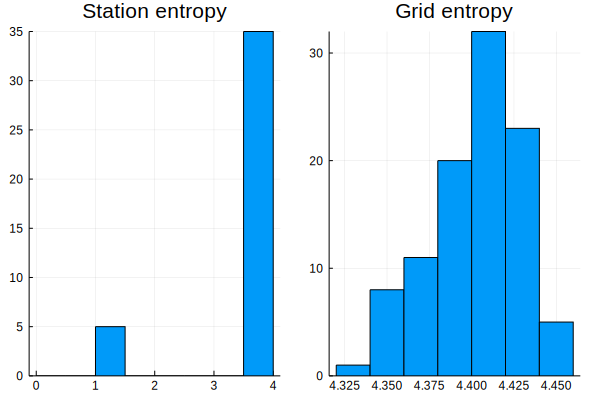

In [29]:
Plots.plot(
  histogram([@views StatsBase.entropy(station_M[i, :]) for i in 1:length(station_lam)], legend=false, title="Station entropy"),
  histogram([@views StatsBase.entropy(testM[i, :]) for i in 1:testRoads], legend=false, title="Grid entropy"))
  

The grid environment, with mostly uniform transition probabilities, shows no improvement with the multi-trip formulation

In [116]:
norm(testA1T2MinPtrs - testA1MinPtrs, 0) / length(testA1MinPtrs)

0.01

single 0.43165957446808506
multi 0.4309414893617021


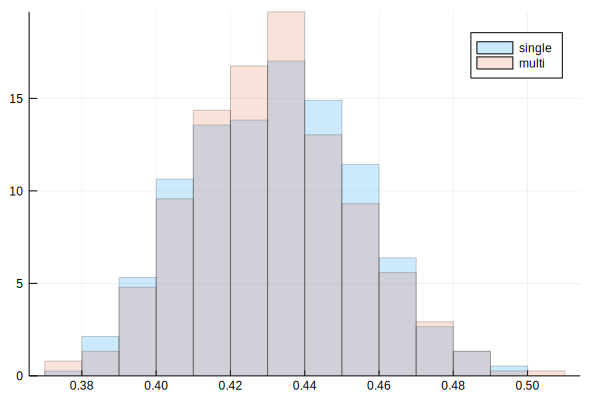

In [33]:
compareFor(indep(testLam), testM, testDists, 5; single=testA1Min, multi=testA1T2Min)

# Example 3: Manhattan

In [138]:
manhattan = getGraph("manhattan.csv");

In [139]:
manhattanG = LG.DiGraph(manhattan.');

In [20]:
manhattan_dists = dists(manhattanG);

In [140]:
manhattan_coords = readcsv("manhattan-coords.csv", Float32);

In [141]:
manhattanRoads = size(manhattan)[1]

4380

In [142]:
kevin = matread("kevin-data.mat");
eveP = kevin["eveP"][:, 1]
mornP = kevin["mornP"][:, 1];

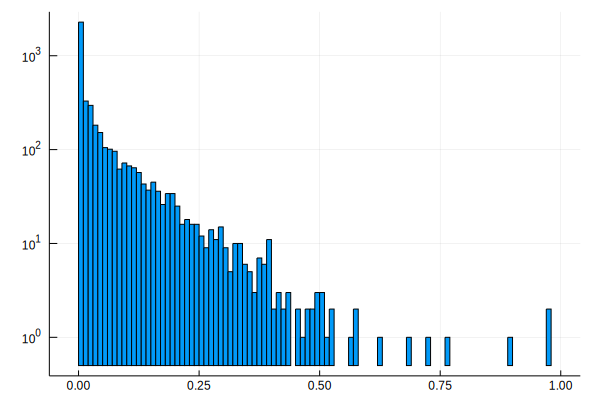

In [154]:
histogram(eveP, yscale=:log10, legend=false)

In [157]:
eve_pol, eve_vals, eve_g, eve_ptrs = a1Min(manhattan, eveP);

Converged in 170 steps


Basins of attraction:

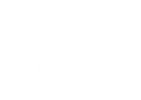

In [146]:
gplot(justCycles(eve_g), manhattan_coords[:,1], -manhattan_coords[:,2], nodesize=eveP, arrowlengthfrac=0.004, nodefillc=colorant"lightblue", edgestrokec=colorant"black")

Distribution of expected waiting times (in minutes)

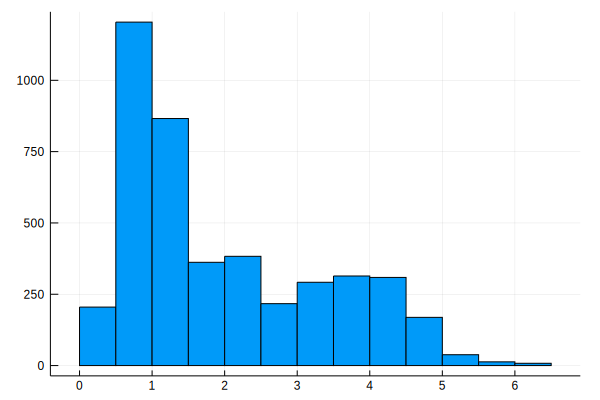

In [155]:
histogram(eve_vals ./ 6, legend=false)

Simulated waiting times with independent pickups trained to look one trip ahead

In [13]:
compareFor(indep(eveP), kevin["eveM"], manhattan_dists, 2; single=constant(eve_pol),
 rand=randPol(manhattan,eveP), greedy=greedyPol(manhattan, eveP))

LoadError: [91mUndefVarError: compareFor not defined[39m

Entropy of next intersection distributions

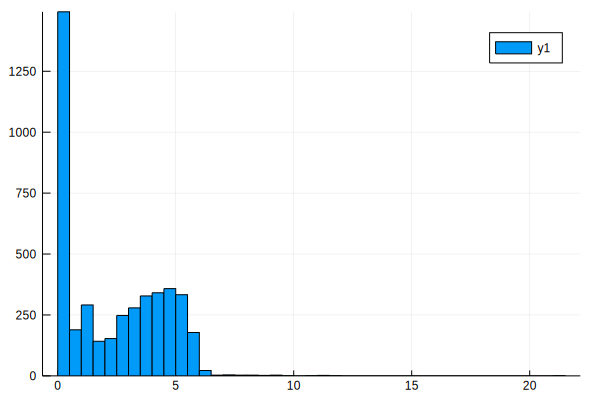

In [75]:
histogram([@views StatsBase.entropy(kevin["eveM"][i, :]) for i in 1:manhattanRoads])

In [160]:
eve_pol2, eve_vals2, eve_g2, eve_ptrs2 = a1T2Min(manhattan, eveP, kevin["eveM"]; ahead=2);

Iteration 1
Converged in 170 steps
Iteration 2
Converged in 146 steps


Strangely, there doesn't seem to be much of a difference

Fraction of routes changed: 0.1415525114155251
single 0.2707131425053863
multi 0.27277146814404435


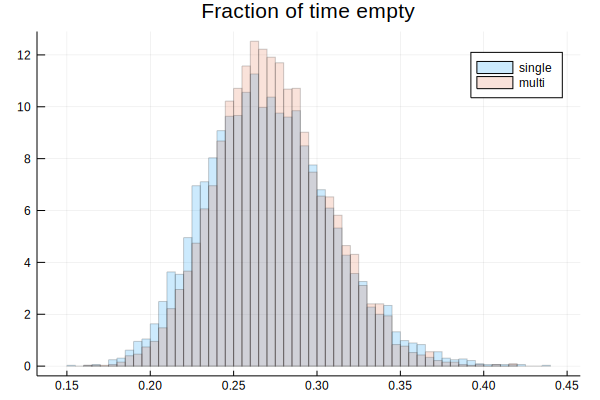

In [161]:
println("Fraction of routes changed: " , norm(eve_ptrs - eve_ptrs2, 0) / length(eve_ptrs))
compareFor(indep(eveP), kevin["eveM"], manhattan_dists, 2; single=eve_pol,
 multi=eve_pol2)

It's not just the entropy that matters. For multi-trip to be a good thing, we have to have it be more likely that we go from a hotspot to a low spot. 

In [26]:
t = @schedule 2 train(manhattan, eveP, 4)

Future(2, 1, 13, Nullable{Any}())

	From worker 2:	Training starting up


In [52]:
schedule(t, StopTraining(), error=true);

0

fatal: error thrown and no exception handler available.
InterruptException()
jl_run_once at /usr/lib/libjulia.so.0.6 (unknown line)
unknown function (ip: 0x7f8fb9abd48a)
unknown function (ip: 0x7f8fb9b3c254)
unknown function (ip: 0x7f8fb9b3c31b)
jl_apply_generic at /usr/lib/libjulia.so.0.6 (unknown line)
unknown function (ip: 0x7f8fbfc85f46)
unknown function (ip: 0x7f8fbfc86011)
unknown function (ip: 0xffffffffffffffff)
Worker 5 terminated.
ERROR (unhandled task failure): EOFError: read end of file


In [ ]:
nycModel = fetch(t);

In [43]:
nycPol= rho->scorePolicy(1 ./ predict(nycModel, rho), manhattan);

Expected 1-trip waiting times with competative pickups

rand 0.9716363636363635
trained 0.9717727272727273
greedy 0.9822272727272728


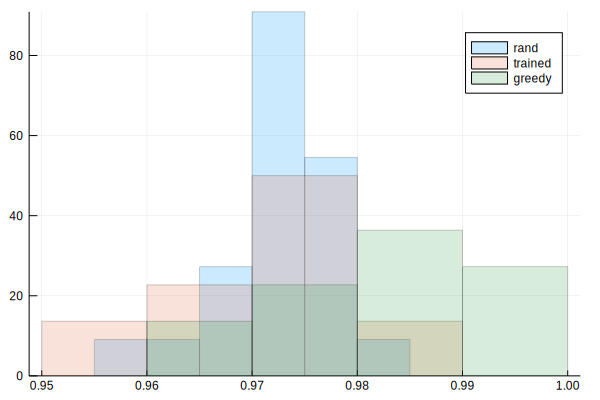

In [45]:
compareFor(compet(eveP), eveM, manhattan_dists, 5; rand=randPol(testA,testLam), trained=nycPol, indep=eve_pol) 